# Push notifications DS

## Milestone 1: Exploration phase

### 1. Filter data:

Get dataset feature_frame_20210304.csv and filter by orders with at least 5 items:

In [1]:
import boto3
import pandas as pd
import numpy as np
import fastparquet
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from sklearn import linear_model
from typing import Tuple

In [2]:
local_file_path = '/home/ebacigalupe/zrive-ds/zrive-ds/src/module_3/feature_frame.csv'  

feature_frame = pd.read_csv(local_file_path)
feature_frame.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [3]:
feature_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [4]:
print(f"Unique number of orders:", feature_frame['order_id'].nunique())

Unique number of orders: 3446


Define columns of the dataset by type: 
- Information columns
- Label
- Features
- Categorical
- Binary
- Numerical

I add this to my code since I saw it in Guille's solution and I liked it.

In [5]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col = 'outcome'
features_cols = [col for col in feature_frame.columns if col not in info_cols + [label_col]]

categorical_cols = ['product_type', 'vendor']
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols = [col for col in features_cols if col not in categorical_cols + binary_cols]

Steps to filter:
1. Group feature_frame by order_id and sum outcome. Only purchased products have outcome = 1.
2. Filter the resulting dataset by number of items per order >= 5.
3. Join feature_frame with feature_frame_orders_bt5 to keep only orders with >= 5 items.

In [6]:
feature_frame_orders = feature_frame.groupby('order_id').outcome.sum()
feature_frame_orders_bt5 = feature_frame_orders[feature_frame_orders >= 5].index
feature_frame_filtered = feature_frame.loc[lambda x: x.order_id.isin(feature_frame_orders_bt5)]
print(f"Unique number of orders:", feature_frame_filtered['order_id'].nunique())


Unique number of orders: 2603


In [7]:
feature_frame_filtered.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


Let's briefly analize how orders behave over time:

In [8]:
feature_frame_filtered['order_date'] = pd.to_datetime(feature_frame_filtered['order_date'])
daily_orders = feature_frame_filtered.groupby('order_date').order_id.nunique()

/tmp/ipykernel_1062/3174384821.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_frame_filtered['order_date'] = pd.to_datetime(feature_frame_filtered['order_date'])


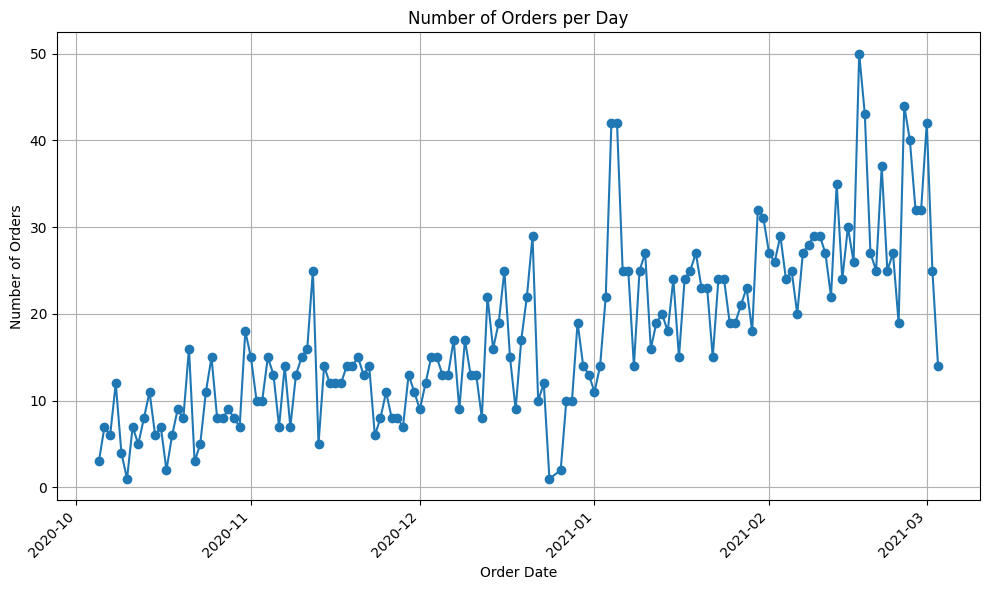

In [9]:
plt.figure(figsize=(10, 6))
daily_orders.plot(marker='o', linestyle='-')
plt.title('Number of Orders per Day')
plt.xlabel('Order Date')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

It is a must to make sure to do a temporal split to avoid data leakage. No order should be split between train and test datasets. To do so, let's compute a cummulative sum of the daily orders:

In [10]:
daily_orders_acc = daily_orders.cumsum()/daily_orders.sum()

In [11]:
train_validation = daily_orders_acc[daily_orders_acc <= 0.7].idxmax()
validation_test = daily_orders_acc[daily_orders_acc <= 0.9].idxmax()

In [12]:
train_feature_frame = feature_frame_filtered[feature_frame_filtered.order_date <= train_validation]
val_feature_frame = feature_frame_filtered[(feature_frame_filtered.order_date > train_validation) &(feature_frame_filtered.order_date <= validation_test)]
test_feature_frame = feature_frame_filtered[feature_frame_filtered.order_date > validation_test]

### 2. PoC - Linear model:

The goal is to build a machine learning model that, given a user and a product, predicts if the
user would purchase it if they were buying with us at that point in time.

A linear model must be applied to feature_frame_filtered using sklearn linear_model.

Model training:

In [13]:
X_train = train_feature_frame.drop(label_col, axis=1)
y_train = train_feature_frame[label_col]

X_val = val_feature_frame.drop(label_col, axis=1)
y_val = val_feature_frame[label_col]

X_test = test_feature_frame.drop(label_col, axis=1)
y_test = test_feature_frame[label_col]


The training will start only with non categorical columns:

In [14]:
train_cols = numerical_cols + binary_cols

#### Baseline

A simple model must be set up to act as a threshold againg more complex models. For this dataset, global popularity feature will be used as baseline. 

In [22]:
!pip install scikit-learn

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use('fast')

In [16]:
def plot_metrics(model_name: str, y_pred: pd.Series, y_test: pd.Series, target_precision: float=0.05, figure: Tuple[matplotlib.figure.Figure, np.array]= None):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14,7))
    else:
        fig, ax = figure
    
    ax[0].plot(recall_, precision_, label=f'{model_name}; (AUC = {pr_auc:.2f})')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision-Recall Curve')
    ax[0].legend(loc='lower right')

    ax[1].plot(fpr, tpr, label=f'(AUC = {roc_auc:.2f})')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate ')
    ax[1].set_title('ROC Curve')
    ax[1].legend(loc='upper center')

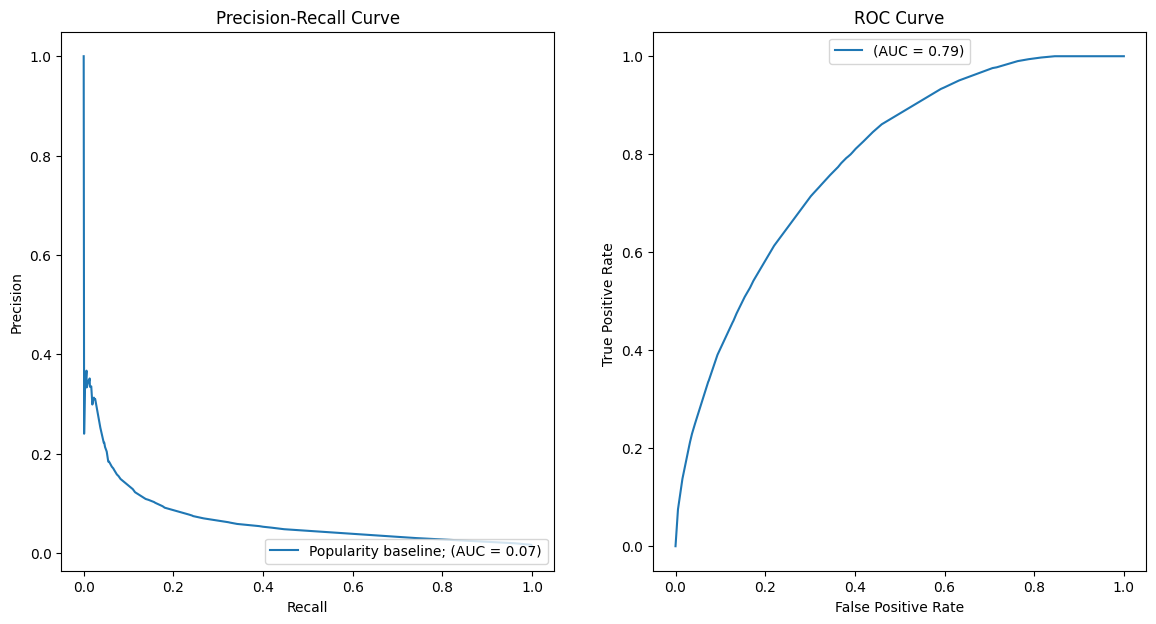

In [17]:
plot_metrics("Popularity baseline", y_pred=val_feature_frame["global_popularity"], y_test=val_feature_frame[label_col])

#### Ridge regularization

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss

InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'elasticnet', 'l2', 'l1'} or None. Got 'none' instead.

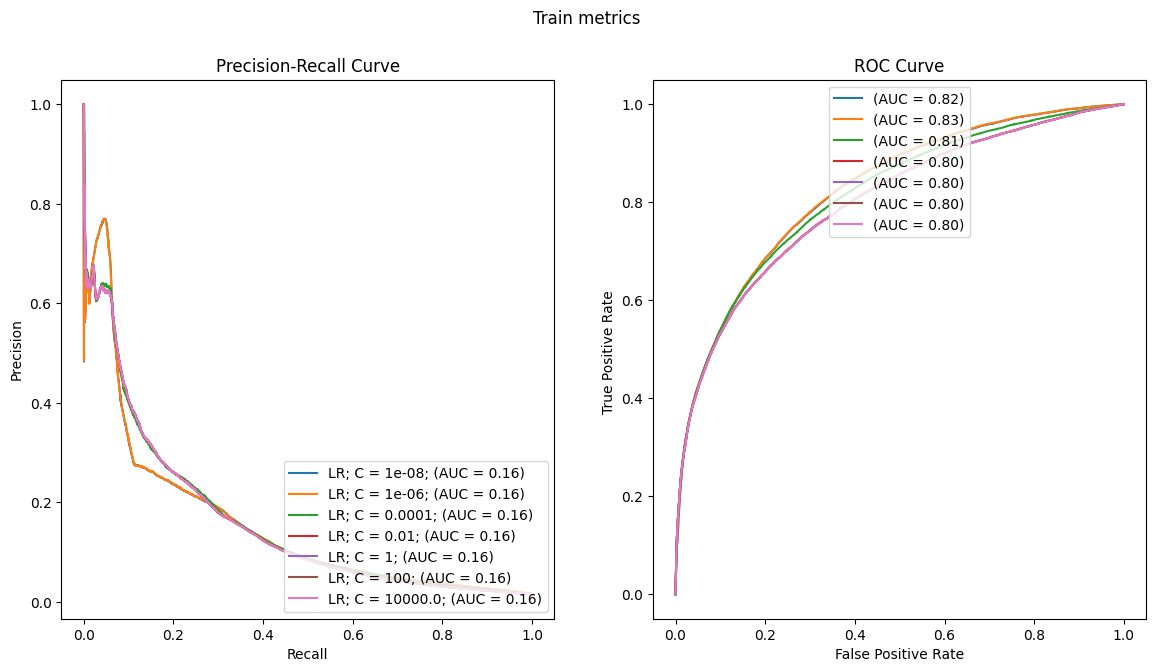

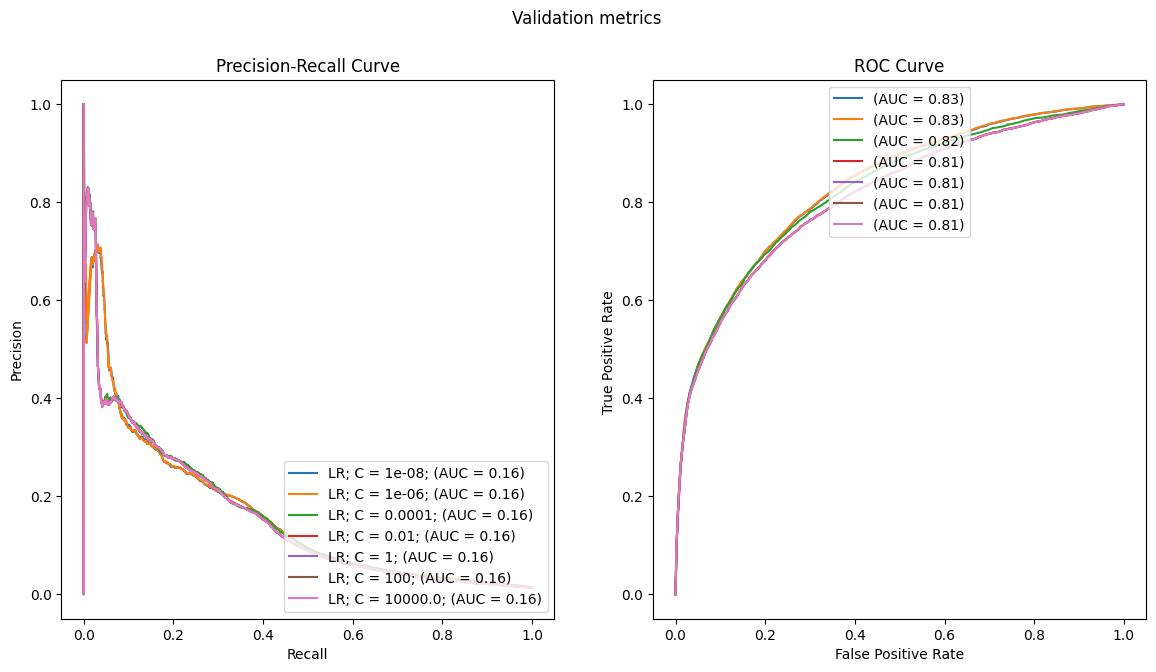

In [18]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty='l2' if c else "none", C=c if c else 1.0)
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"LR; C = {c}", y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"LR; C = {c}", y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))
plot_metrics(f"Baseline", y_pred=val_feature_frame['global_popularity'], y_test=val_feature_frame[label_col], figure=(fig2, ax2))


#### Lasso regularization 

InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'elasticnet', 'l2', 'l1'} or None. Got 'none' instead.

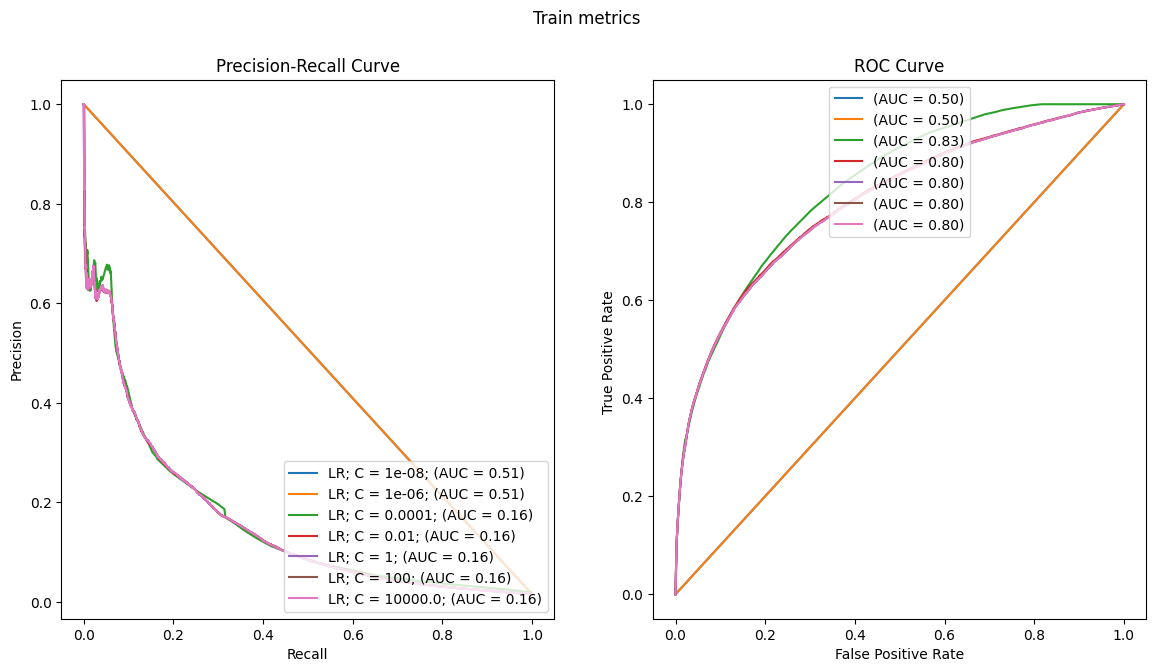

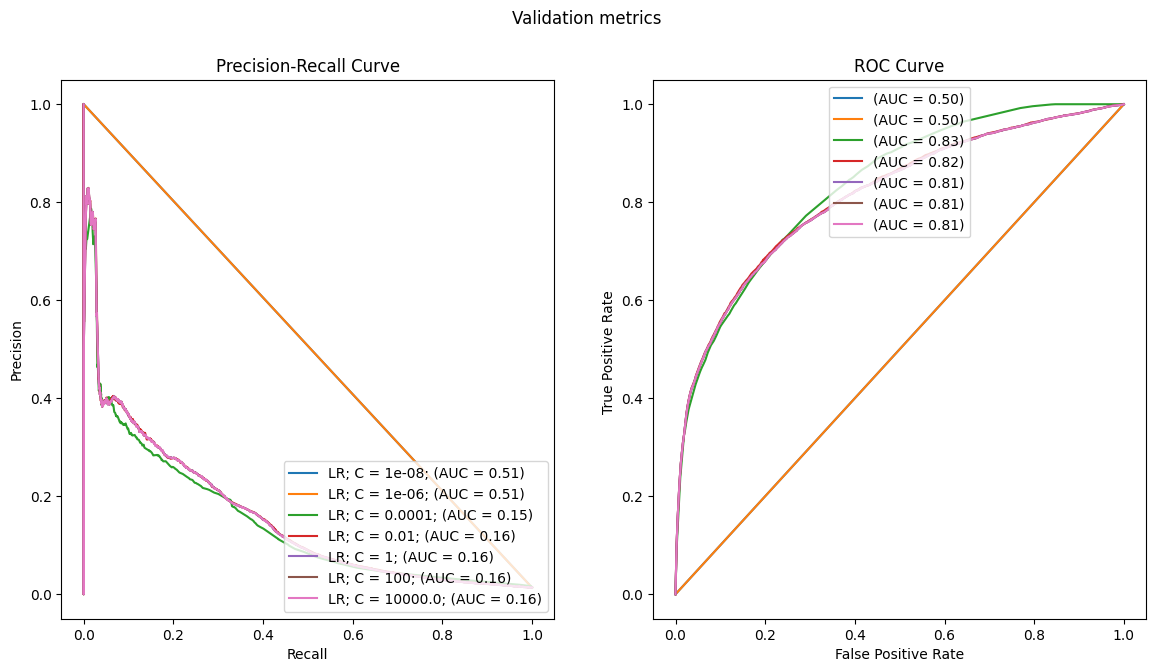

In [19]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]
cmap = plt.get_cmap('Paired')
for c in cs:
    lr = make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1" if c else "none", C=c if c else 1.0, solver ="saga")
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"LR; C = {c}", y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"LR; C = {c}", y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))

plot_metrics(f"Baseline", y_pred=val_feature_frame['global_popularity'], y_test=val_feature_frame[label_col], figure=(fig2, ax2))


#### Coefficients weights:

In [20]:
lr = Pipeline([("standard_scaler", StandardScaler()), ("lr", LogisticRegression(penalty="l2", C=1e-6))])
lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame({"features": train_cols, "importance": np.abs(lr.named_steps["lr"].coef_[0]),
                            "regularisation": ["l2"] * len(train_cols)})
lr_coeff_l2 = lr_coeff_l2.sort_values('importance', ascending=True)

lr = Pipeline([("standard_scaler", StandardScaler()), ("lr", LogisticRegression(penalty="l1", C=1e-4, solver="saga"))])
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame({"features": train_cols, "importance": np.abs(lr.named_steps["lr"].coef_[0]),
                            "regularisation": "l1"})
lr_coeff_l1 = lr_coeff_l1.sort_values('importance', ascending=True)

<Axes: xlabel='importance', ylabel='features'>

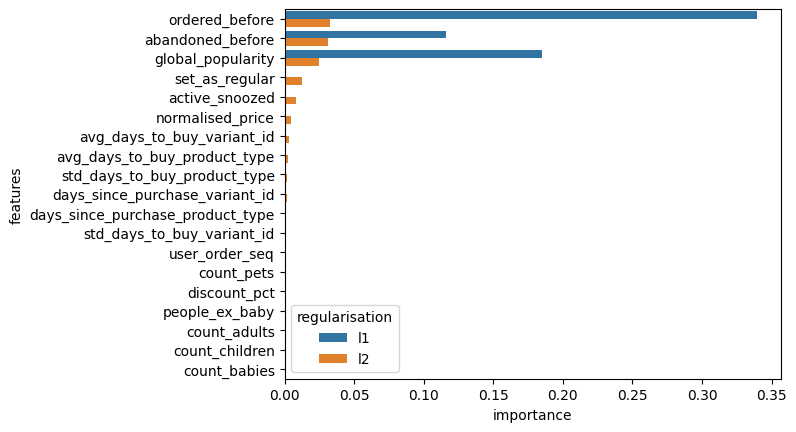

In [21]:
lr_coeffs = pd.concat([lr_coeff_l2, lr_coeff_l1])
lr_coeffs["features"] = pd.Categorical(lr_coeffs["features"])
lr_coeffs = lr_coeffs.sort_values(by=["importance"])
order_columns = lr_coeff_l2.sort_values(by="importance", ascending=False)["features"]
sns.barplot(data=lr_coeffs, x="importance", y="features", hue="regularisation", order=order_columns)

The model is going to be trained again without non important variables based on L1

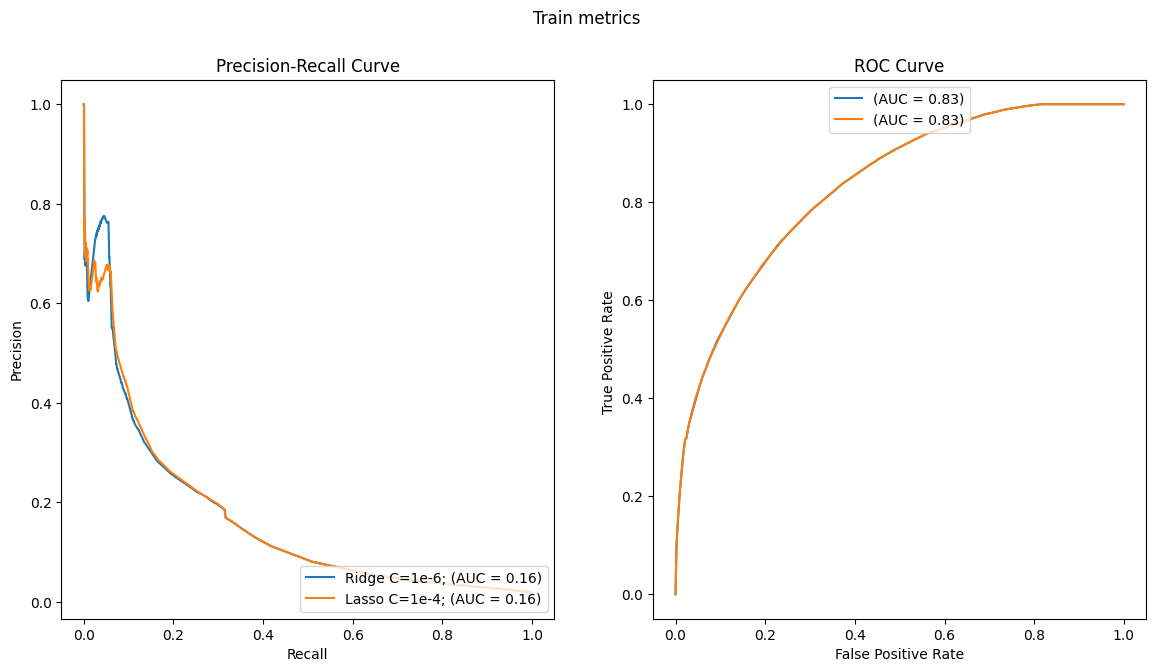

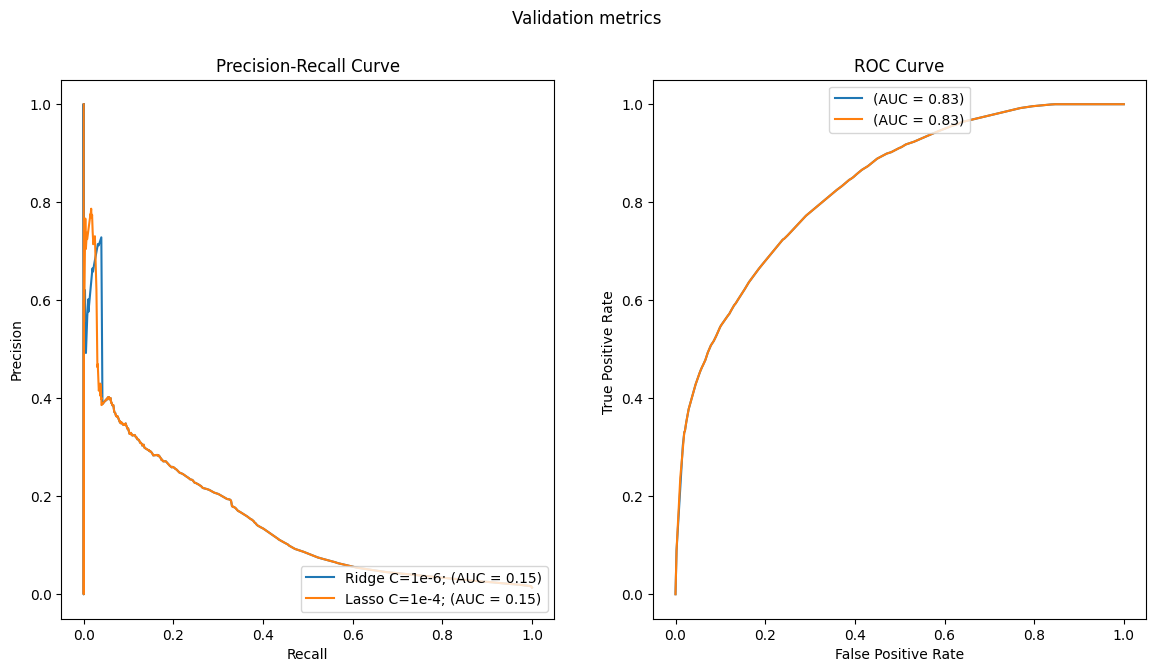

In [22]:
reduced_cols = ['ordered_before', 'abandoned_before', 'global_popularity']

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l2", C=1e-6)
    ),
    make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", C=1e-4, solver="saga")
    ),
]

names = ['Ridge C=1e-6', "Lasso C=1e-4"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(name, y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(name, y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))

A linear model can be trained over few features and get same results as a model with several features.

#### Categorical encoding:

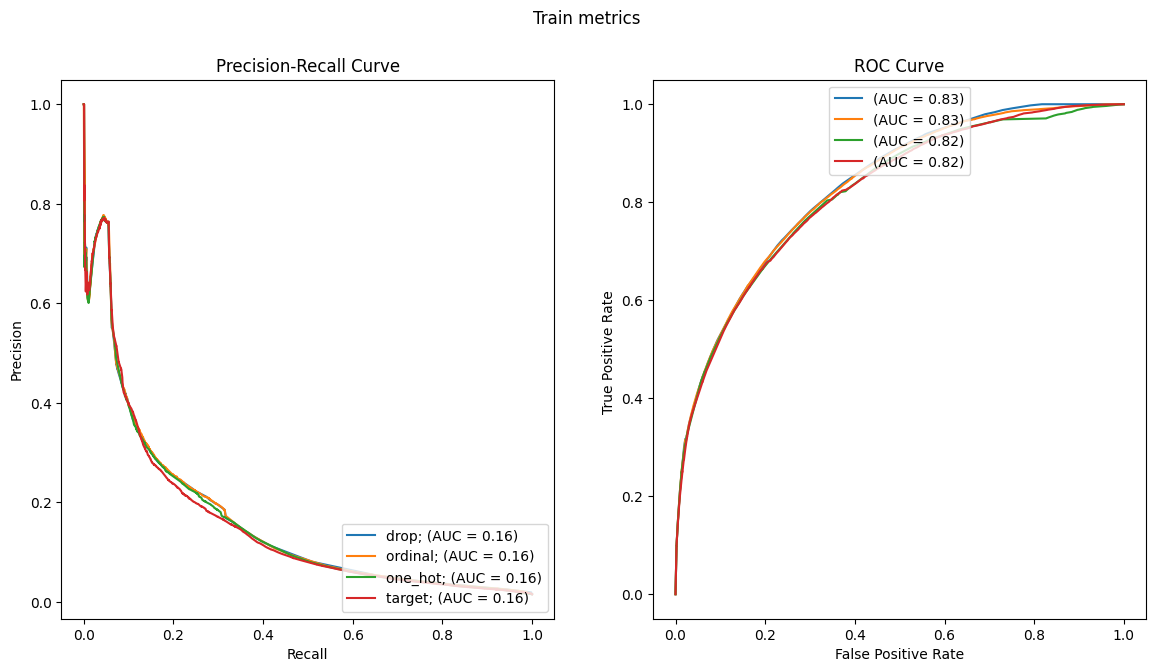

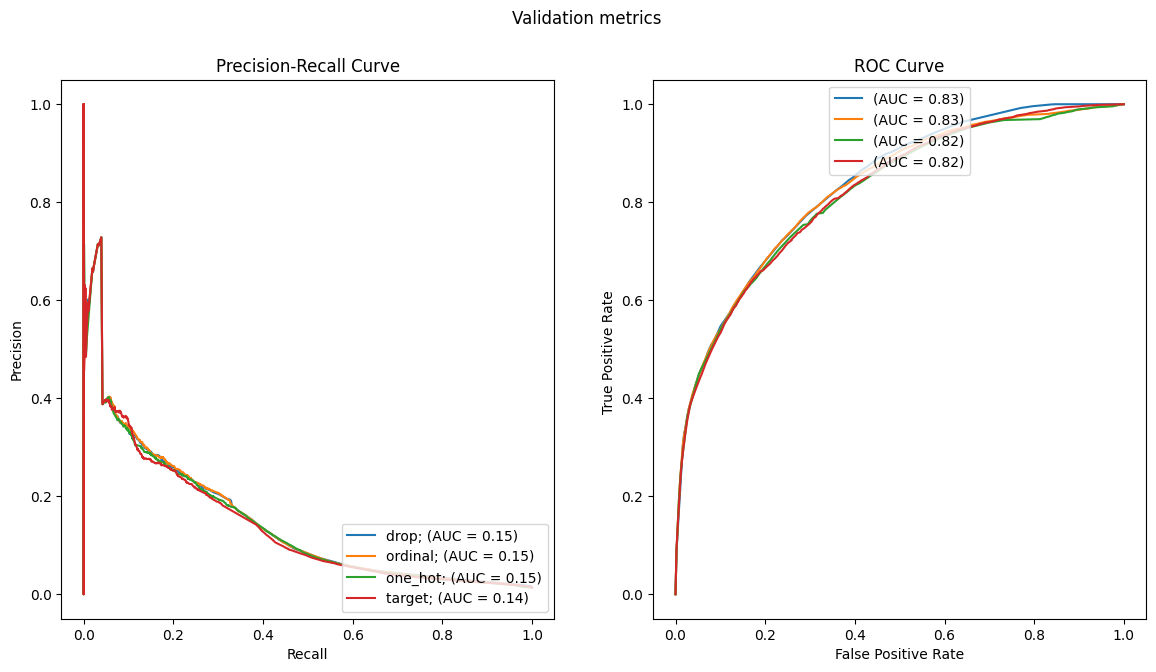

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder

categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous"))
]

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

extended_cols = reduced_cols + categorical_cols

for name, categorical_preprocessors in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", reduced_cols),
            ("categorical", categorical_preprocessors, categorical_cols),
        ]
    )
    lr = make_pipeline(
        preprocessor,
        StandardScaler(),
        LogisticRegression(penalty="l2", C=1e-6)
    )

    lr.fit(X_train[extended_cols], y_train)
    train_proba = lr.predict_proba(X_train[extended_cols])[:, 1]
    plot_metrics(name, y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

    val_proba = lr.predict_proba(X_val[extended_cols])[:, 1]
    plot_metrics(name, y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))

### 3. PoC - Non-Linear model:

Need to also take into account non-linear models to try to improve previous outcomes.

#### Random forest:

In [24]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

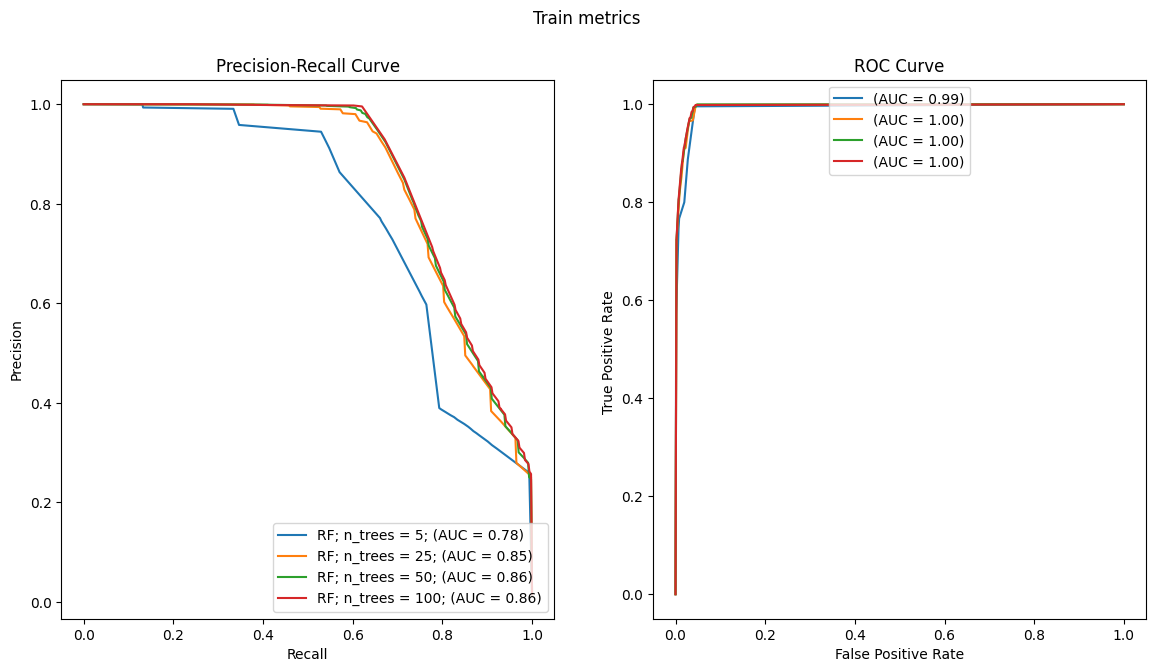

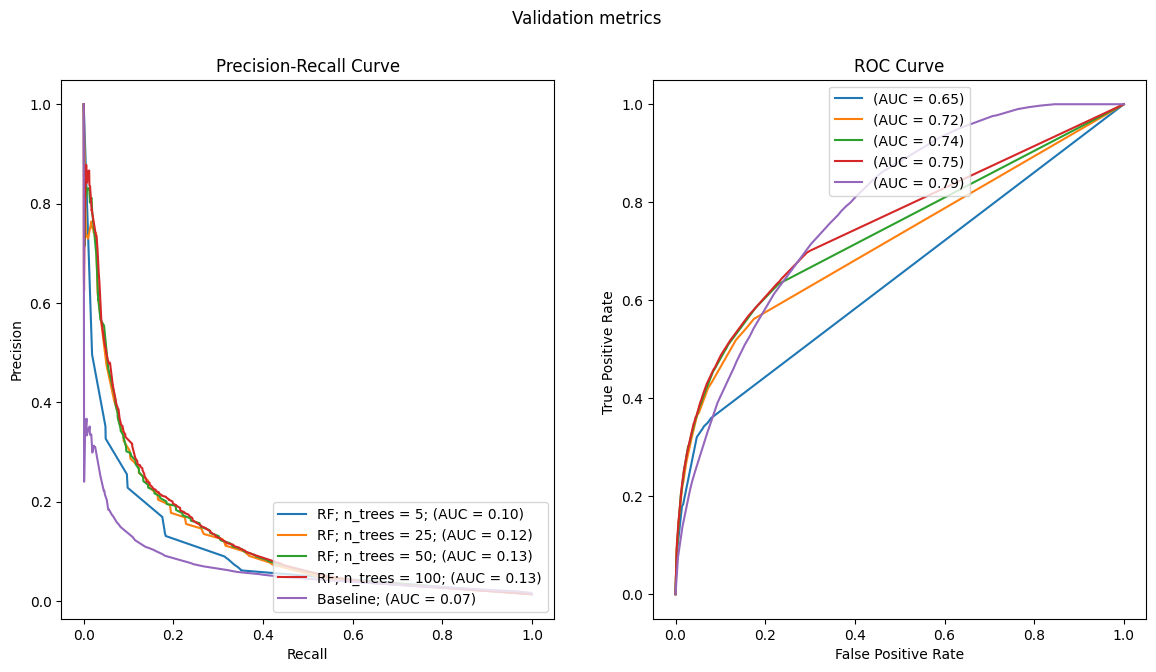

In [28]:
rf_push_train_aucs = []
rf_push_val_aucs = []
rf_push_train_ce = []
rf_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

n_trees_grid = [5, 25, 50, 100]
for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train[train_cols], y_train)
    train_proba = rf.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"RF; n_trees = {n_trees}", y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

    val_proba = rf.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"RF; n_trees = {n_trees}", y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))
plot_metrics(f"Baseline", y_pred=val_feature_frame['global_popularity'], y_test=val_feature_frame[label_col], figure=(fig2, ax2))

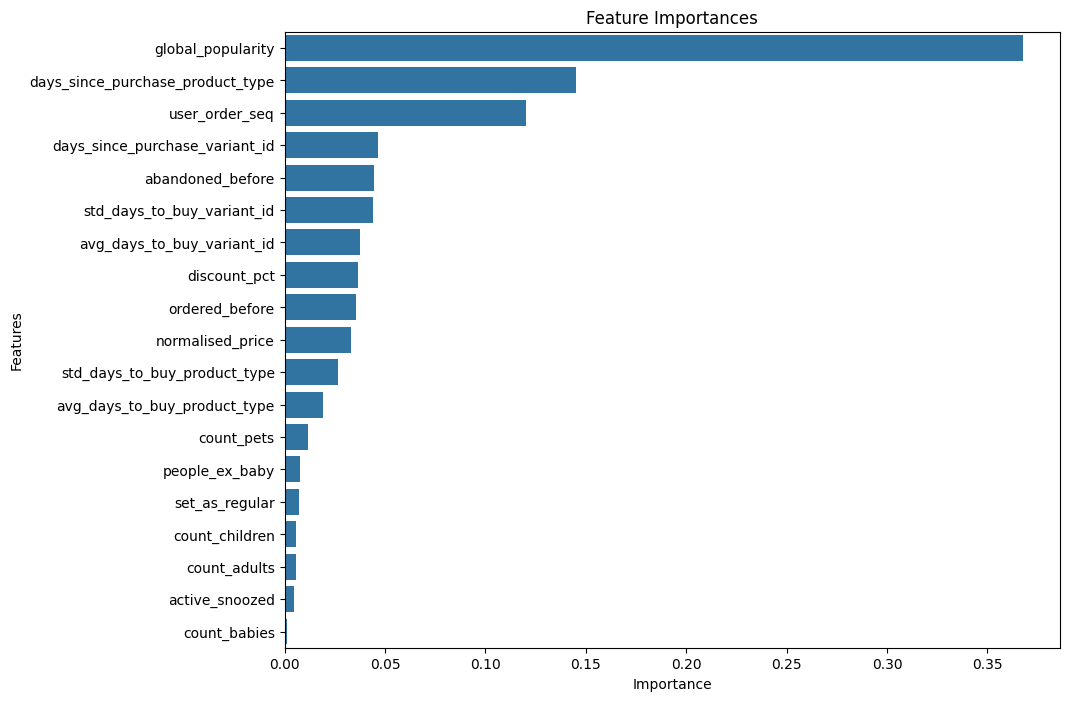

In [42]:
rf = RandomForestClassifier(100)
rf.fit(X_train[train_cols], y_train)

feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({"features": train_cols, "importance": feature_importances})

feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x="importance", y="features")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
plt.show()

Let's try retraining the model with the most importante features

In [44]:
train_important_cols = feature_importance_df["features"].iloc[:15]

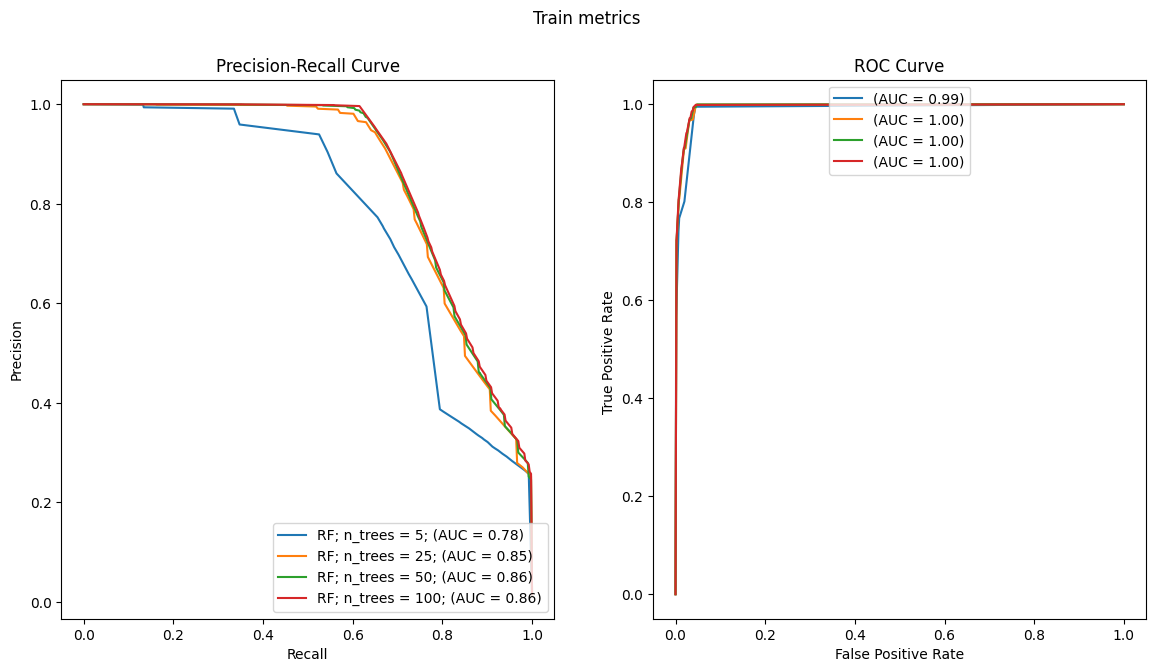

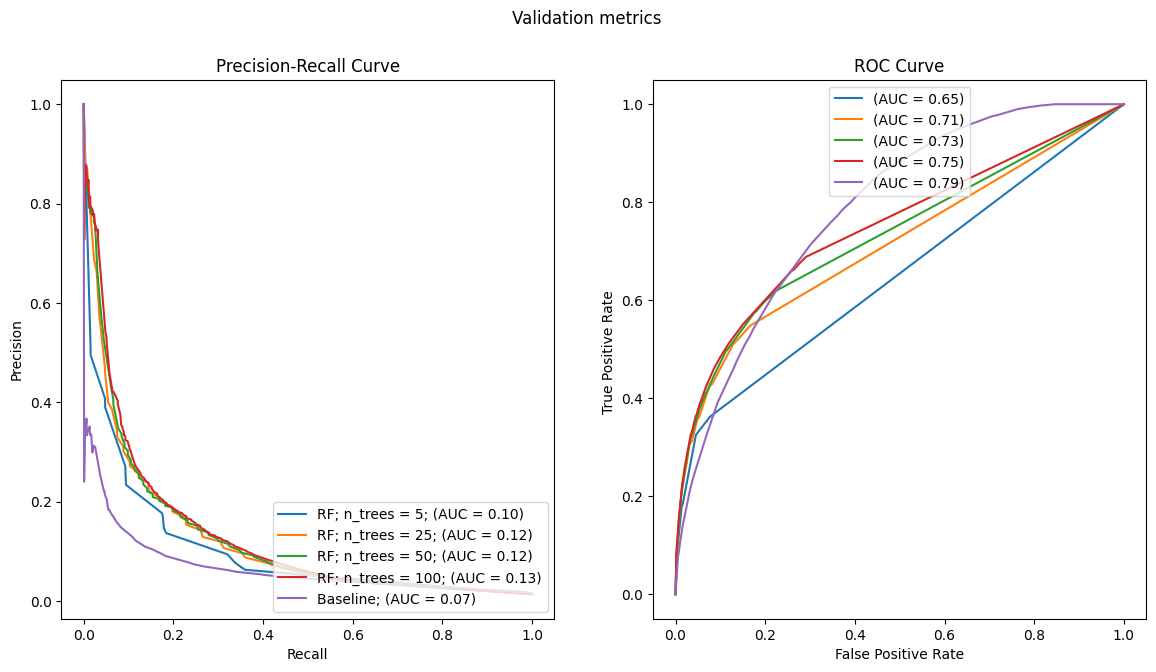

In [45]:
rf_push_train_aucs = []
rf_push_val_aucs = []
rf_push_train_ce = []
rf_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

n_trees_grid = [5, 25, 50, 100]
for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train[train_important_cols], y_train)
    train_proba = rf.predict_proba(X_train[train_important_cols])[:, 1]
    plot_metrics(f"RF; n_trees = {n_trees}", y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

    val_proba = rf.predict_proba(X_val[train_important_cols])[:, 1]
    plot_metrics(f"RF; n_trees = {n_trees}", y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))
plot_metrics(f"Baseline", y_pred=val_feature_frame['global_popularity'], y_test=val_feature_frame[label_col], figure=(fig2, ax2))

#### Gradient boosting trees:

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

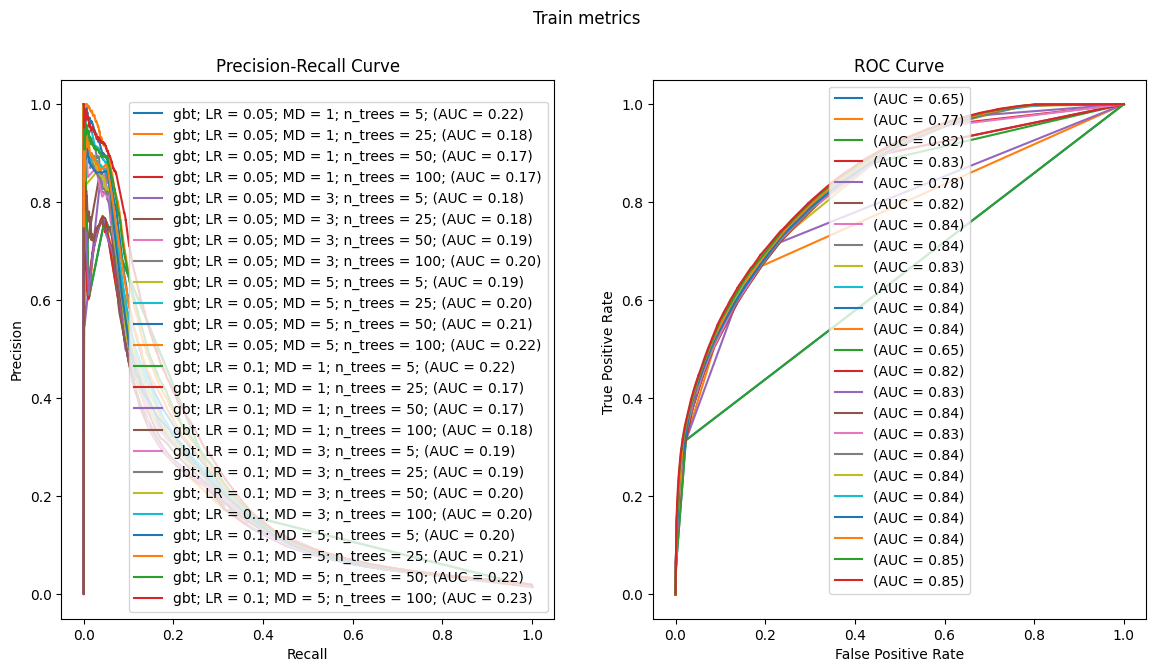

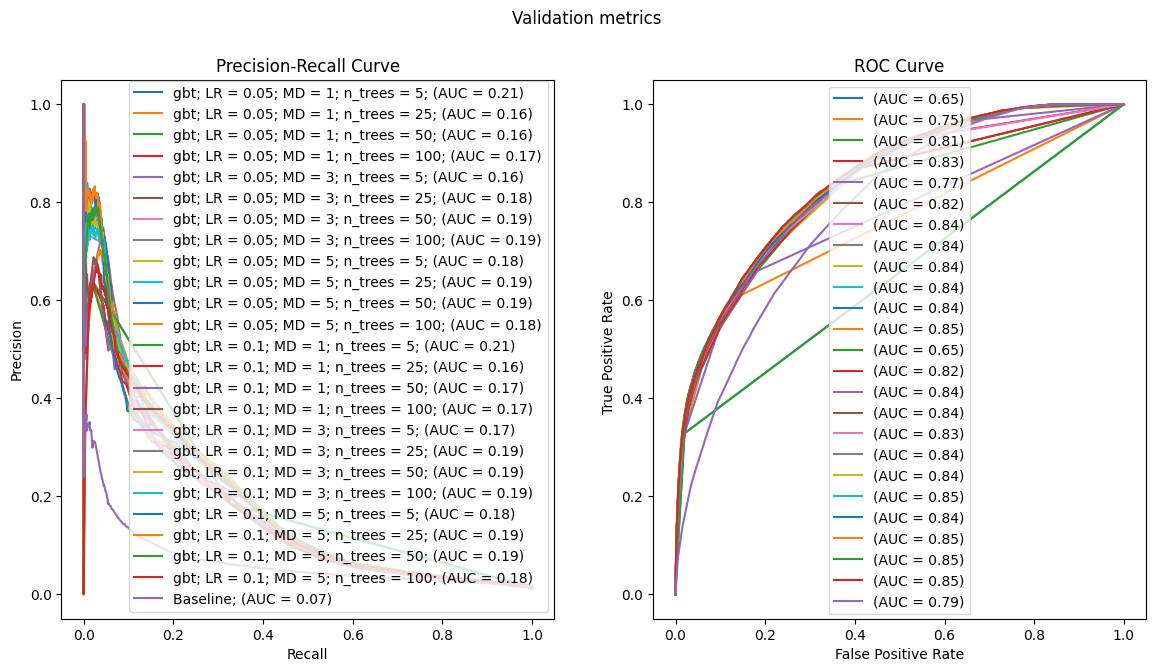

In [91]:
gbt_push_train_aucs = []
gbt_push_val_aucs = []
gbt_push_train_ce = []
gbt_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

n_trees_grid = [5, 25, 50, 100]
for lr in [0.05, 0.1]:
    for depth in [1, 3, 5]:
        for n_trees in n_trees_grid:
            gbt = GradientBoostingClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n_trees
            )
            gbt.fit(X_train[train_cols], y_train)
            train_proba = gbt.predict_proba(X_train[train_cols])[:, 1]
            plot_metrics(f"gbt; LR = {lr}; MD = {depth}; n_trees = {n_trees}", y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

            val_proba = gbt.predict_proba(X_val[train_cols])[:, 1]
            plot_metrics(f"gbt; LR = {lr}; MD = {depth}; n_trees = {n_trees}", y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))
plot_metrics(f"Baseline", y_pred=val_feature_frame['global_popularity'], y_test=val_feature_frame[label_col], figure=(fig2, ax2))

In [92]:
lr_best = 0.1
max_depth_best = 3
n_estimators_best = 100

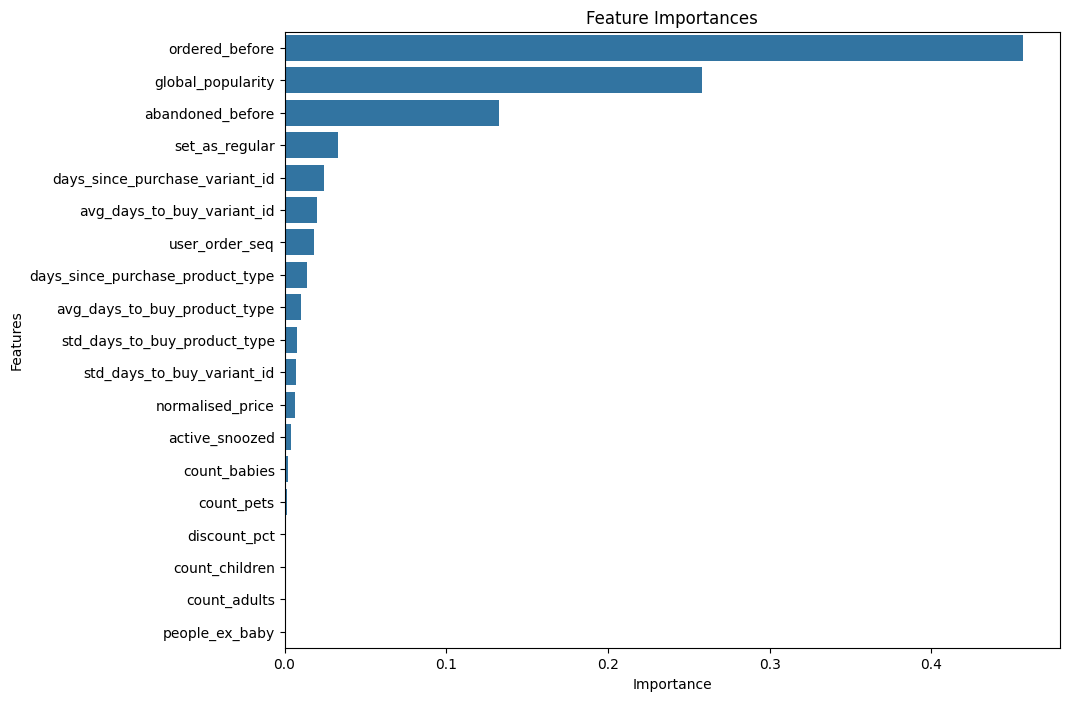

In [93]:
gbt = GradientBoostingClassifier(
        learning_rate=lr_best, max_depth=max_depth_best, n_estimators=n_estimators_best
)
gbt.fit(X_train[train_cols], y_train)

feature_importances_gbt = gbt.feature_importances_

feature_importance_df_gbt = pd.DataFrame({"features": train_cols, "importance": feature_importances_gbt})

feature_importance_df_gbt = feature_importance_df_gbt.sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df_gbt, x="importance", y="features")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances")
plt.show()

In [94]:
train_important_cols_gbt = (
    feature_importance_df_gbt.loc[feature_importance_df_gbt["importance"] > 0]
    .sort_values(by="importance", ascending=False)["features"]
    .tolist()
)

train_important_cols_gbt = train_important_cols_gbt[:15]

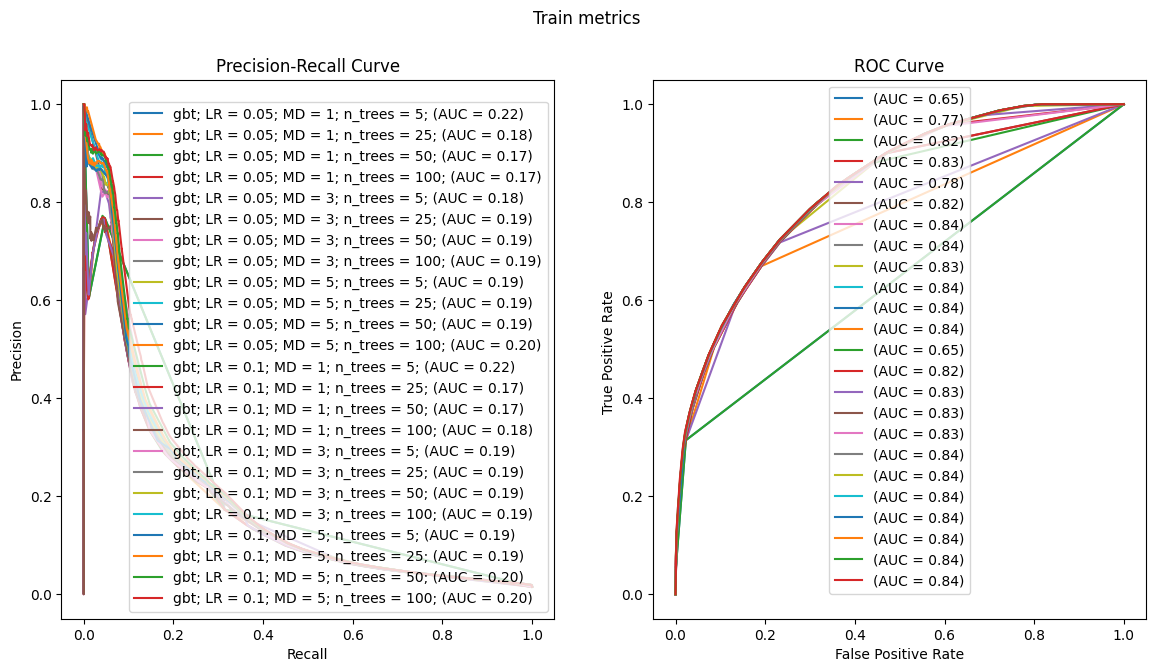

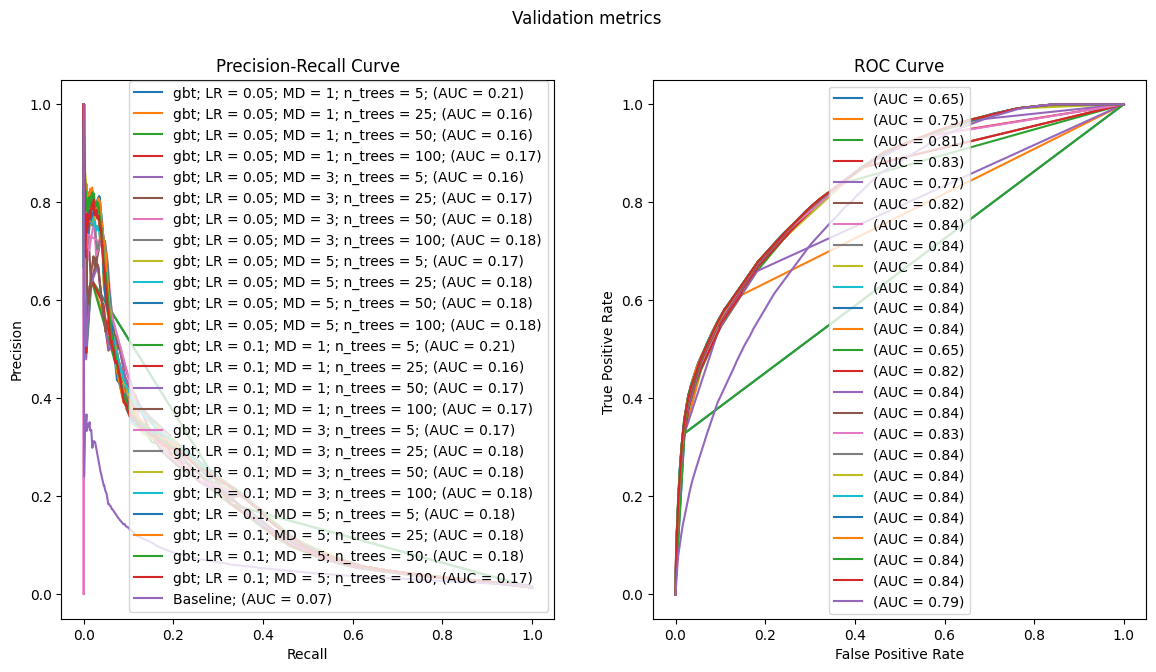

In [51]:
gbt_push_train_aucs = []
gbt_push_val_aucs = []
gbt_push_train_ce = []
gbt_push_val_ce = []

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

n_trees_grid = [5, 25, 50, 100]
for lr in [0.05, 0.1]:
    for depth in [1, 3, 5]:
        for n_trees in n_trees_grid:
            gbt = GradientBoostingClassifier(
                learning_rate=lr, max_depth=depth, n_estimators=n_trees
            )
            gbt.fit(X_train[train_important_cols_gbt], y_train)
            train_proba = gbt.predict_proba(X_train[train_important_cols_gbt])[:, 1]
            plot_metrics(f"gbt; LR = {lr}; MD = {depth}; n_trees = {n_trees}", y_pred = train_proba, y_test = train_feature_frame[label_col], figure = (fig1, ax1))

            val_proba = gbt.predict_proba(X_val[train_important_cols_gbt])[:, 1]
            plot_metrics(f"gbt; LR = {lr}; MD = {depth}; n_trees = {n_trees}", y_pred = val_proba, y_test = val_feature_frame[label_col], figure = (fig2, ax2))
plot_metrics(f"Baseline", y_pred=val_feature_frame['global_popularity'], y_test=val_feature_frame[label_col], figure=(fig2, ax2))

### 4. Comparing models:

In [87]:
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

In [88]:
def plot_model_metrics(model_names, predictions, y_true):
    plt.figure(figsize=(14, 7))

    # Precision-Recall Curve
    plt.subplot(1, 2, 1)
    for model_name, y_pred in zip(model_names, predictions):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        plt.plot(recall, precision, label=f'{model_name} (AP = {average_precision_score(y_true, y_pred):.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    # ROC Curve
    plt.subplot(1, 2, 2)
    for model_name, y_pred in zip(model_names, predictions):
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_pred):.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    plt.show()

In [95]:
rf = RandomForestClassifier(100)
rf.fit(X_train[train_important_cols], y_train)
rf_predictions = rf.predict_proba(X_val[train_important_cols])[:, 1]
print("RF important columns")

rf_all = RandomForestClassifier(100)
rf_all.fit(X_train[train_cols], y_train)
rf_all_predictions = rf_all.predict_proba(X_val[train_cols])[:, 1]
print("RF all columns")

gbt = GradientBoostingClassifier(
        learning_rate=lr_best, max_depth=max_depth_best, n_estimators=n_estimators_best
)
gbt.fit(X_train[train_important_cols_gbt], y_train)
gbt_predictions = gbt.predict_proba(X_val[train_important_cols_gbt])[:, 1]
print("GBT important columns")

reduced_cols = ['ordered_before', 'abandoned_before', 'global_popularity']

lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", C=1e-04, solver="saga")
)
lr.fit(X_train[reduced_cols], y_train)
lr_predictions = lr.predict_proba(X_val[reduced_cols])[:, 1]
print("Logistic regression")

RF important columns
RF all columns
GBT important columns
Logistic regression


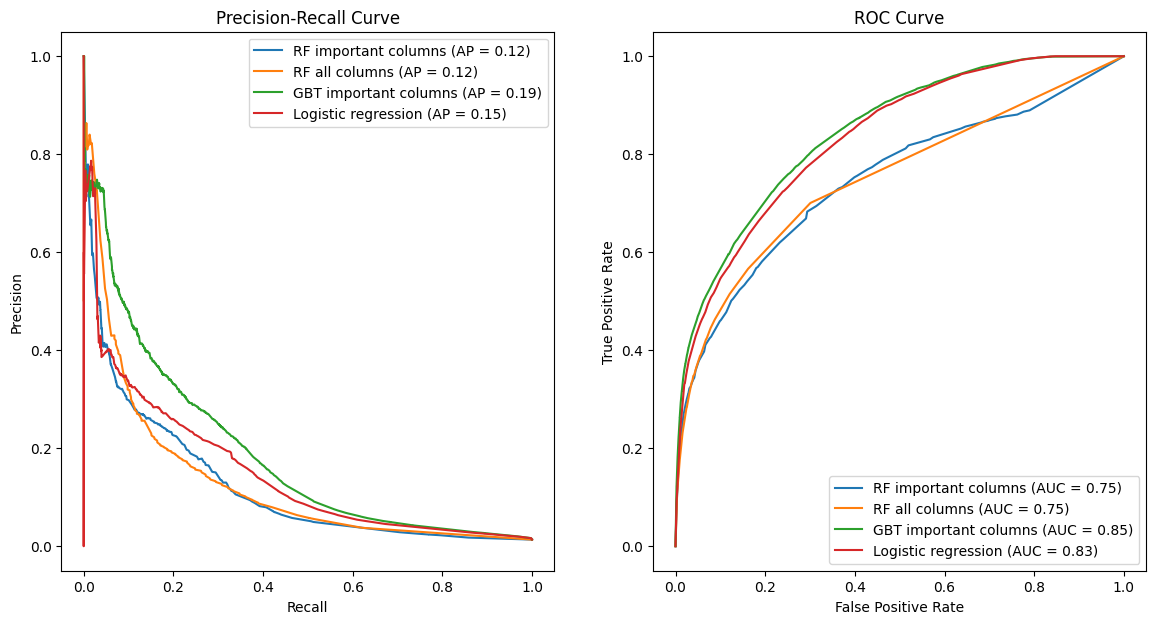

In [96]:
model_names = ["RF important columns", "RF all columns", "GBT important columns", "Logistic regression"]
predictions = [rf_predictions, rf_all_predictions, gbt_predictions, lr_predictions]

plot_model_metrics(model_names, predictions, y_val)

GBT is the best model for this scenario

### 5. Calibration:

In [97]:
from sklearn.calibration import calibration_curve

In [98]:
lr_prob_true, lr_prob_pred = calibration_curve(y_val, lr_predictions, n_bins=20)
gbt_prob_true, gbt_prob_pred = calibration_curve(y_val, gbt_predictions, n_bins=20)

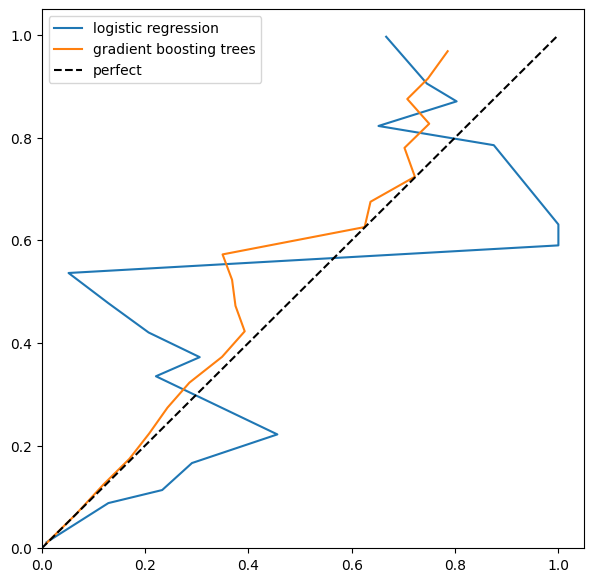

In [100]:
fig, ax= plt.subplots(figsize=(7, 7))

ax.plot(lr_prob_true, lr_prob_pred, label="logistic regression")
ax.plot(gbt_prob_true, gbt_prob_pred, label="gradient boosting trees")
ax.plot([0,1], [0,1], color="k", linestyle="--", label="perfect")
ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.05)
ax.legend()

GBT is better calibrated

In [101]:
from sklearn.calibration import CalibratedClassifierCV

In [102]:
calibrated_lr = CalibratedClassifierCV(lr, cv="prefit", method="isotonic")
calibrated_gbt = CalibratedClassifierCV(gbt, cv="prefit", method="isotonic")

In [103]:
calibrated_lr.fit(X_val[reduced_cols], y_val)
val_lr_calibrated_pred = calibrated_lr.predict_proba(X_val[reduced_cols])[:, 1]
test_lr_calibrated_pred = calibrated_lr.predict_proba(X_test[reduced_cols])[:, 1]

calibrated_gbt.fit(X_val[train_important_cols_gbt], y_val)
val_gbt_calibrated_pred = calibrated_gbt.predict_proba(X_val[train_important_cols_gbt])[:, 1]
test_gbt_calibrated_pred = calibrated_gbt.predict_proba(X_test[train_important_cols_gbt])[:, 1]

In [104]:
lr_prob_true_val_calibrated, lr_prob_pred_val_calibrated = calibration_curve(
    y_val, val_lr_calibrated_pred, n_bins=20
)
lr_prob_true_test_calibrated, lr_prob_pred_test_calibrated = calibration_curve(
    y_test, test_lr_calibrated_pred, n_bins=20
)

gbt_prob_true_val_calibrated, gbt_prob_pred_val_calibrated = calibration_curve(
    y_val, val_gbt_calibrated_pred, n_bins=20
)
gbt_prob_true_test_calibrated, gbt_prob_pred_test_calibrated = calibration_curve(
    y_test, test_gbt_calibrated_pred, n_bins=20
)

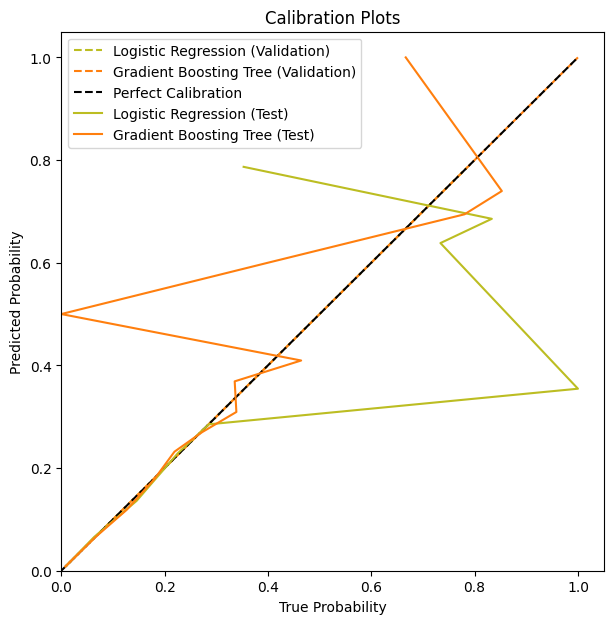

In [106]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(lr_prob_true_val_calibrated, lr_prob_pred_val_calibrated, label="Logistic Regression (Validation)", color="C8", linestyle="--")
ax.plot(gbt_prob_true_val_calibrated, gbt_prob_pred_val_calibrated, label="Gradient Boosting Tree (Validation)", color="C1", linestyle="--")
ax.plot([0, 1], [0, 1], color="k", linestyle="--", label="Perfect Calibration")

ax.plot(lr_prob_true_test_calibrated, lr_prob_pred_test_calibrated, label="Logistic Regression (Test)", color="C8")
ax.plot(gbt_prob_true_test_calibrated, gbt_prob_pred_test_calibrated, label="Gradient Boosting Tree (Test)", color="C1")

ax.set_ylim(0, 1.05)
ax.set_xlim(0, 1.05)
ax.set_xlabel("True Probability")
ax.set_ylabel("Predicted Probability")
ax.legend()
plt.title("Calibration Plots")
plt.show()


GBT is still better calibrated besides not been proper calibrated at all.

### 6. Assesing final performance:

In [108]:
from sklearn.metrics import precision_recall_fscore_support

In [107]:
th = 0.05
gbt_test_binary_pred = (test_gbt_calibrated_pred > th).astype(int)
lr_test_binary_pred = (test_lr_calibrated_pred > th).astype(int)

In [109]:
def get_model_binary_metrics(y_true, y_pred, name=""):
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    results = pd.Series(
        {
            "precision": precision[1],
            "recall": recall[1],
            "f1": f1[1],
            "prevalence": support[1] / (support[0] + support[1])
        },
        name=name,
    )
    return results

In [110]:
gbt_test_results = get_model_binary_metrics(y_test, gbt_test_binary_pred, name="gbt")
lr_test_results = get_model_binary_metrics(y_test, lr_test_binary_pred, name="lr")

test_results = pd.concat([gbt_test_results, lr_test_results], axis=1)

In [111]:
test_results

,gbt,lr
precision,0.155138,0.145403
recall,0.411262,0.375295
f1,0.225291,0.209599
prevalence,0.012874,0.012874
